# Missing Tree Analysis - Aerobotics Challenge, Cape Town, South Africa

This notebook is using data from the developers API at Aerobotics. The goal is to investigate the data and find what the locations are of specific missing trees!

Some key areas of investigation will be:

## (1) Tree Survey Dataset:
- What does the actual tree data look like when plotted on a map?
    - What is the average distance between the trees in the orchard?
    - Are you able to spot the missing trees easily 


In [68]:
import os
import psycopg2
import psycopg2.extras as extras
from io import StringIO
from datetime import datetime, timedelta
import requests
import json
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from math import radians, cos, sin, asin, sqrt
from sklearn.neighbors import BallTree, KDTree
%matplotlib inline

# Fetch the data
my_headers = {'Authorization' : '{{apikey}}'}

response = requests.get('{{treesurvey_url}}', headers=my_headers)
survey = requests.get('{{surveys_url}}', headers=my_headers)

treesurvey_response = response.json()
survey_response = survey.json()

treesurvey_df = pd.DataFrame(treesurvey_response['results'])
survey_df = pd.DataFrame(survey_response['results'])

def findorch_id(survey_id):
    return survey_df.loc[survey_df['id'] == survey_id]['orchard_id'][0]           

treesurvey_df["orchard_id"] = treesurvey_df.apply(lambda x: findorch_id(x.survey_id), axis=1)
treesurvey_df.head()

,area,height,id,latitude,longitude,ndre,ndvi,radius,survey_id,tree_id,volume,orchard_id
0,20.703,2.928,54732944,-32.327591,18.826167,0.639,0.893,2.567,25319,38869352,35.639,216269
1,22.964,2.571,54732945,-32.327561,18.826040,0.608,0.900,2.704,25319,38869351,37.536,216269
2,23.039,2.916,54732946,-32.327546,18.825974,0.572,0.869,2.708,25319,38869350,44.041,216269
3,19.014,2.783,54732947,-32.327571,18.826103,0.607,0.913,2.460,25319,38869349,36.735,216269
4,23.766,3.220,54732948,-32.327561,18.825765,0.614,0.877,2.750,25319,38869348,43.370,216269


#### Tree Data immediate view
- We see a list of tree ids and their respective lats & longs
- there are other descriptive variables like area, height,radius, volume, ndre (Normalized Difference Red Edge Index), ndvi(Normalized difference vegetation index) - thanks Google! 
- Lets try plot these to a map to visualize the lats and longs
- To do this we use the Open Street Map site (https://www.openstreetmap.org/) to download a png of the specific area
- The specific area is worked out by looking at the min and max for the latitudes and longitudes (note bbox variable below)

In [39]:
bbox = ((treesurvey_df.longitude.min(), treesurvey_df.longitude.max(), treesurvey_df.latitude.min(), treesurvey_df.latitude.max()))
farm_map = plt.imread('map.png')

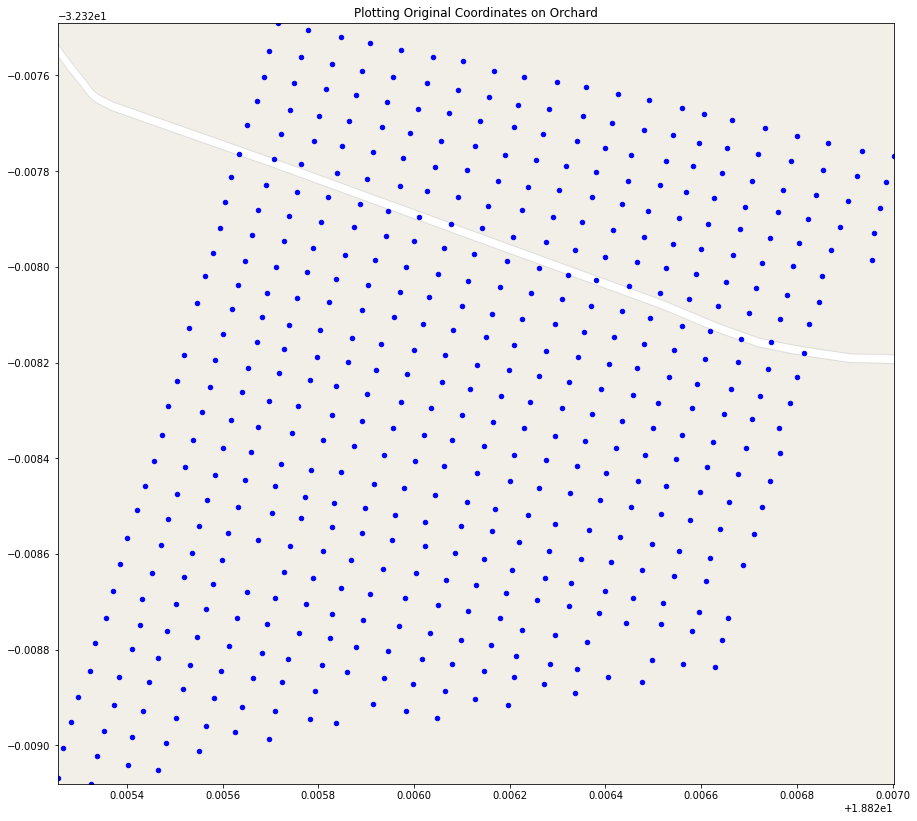

In [40]:
fig, ax = plt.subplots(figsize = (15,14))

ax.scatter(treesurvey_df.longitude, treesurvey_df.latitude, zorder=1, alpha = 1, c='b', s=20)
ax.set_title('Plotting Original Coordinates on Orchard')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2], bbox[3])

ax.imshow(farm_map, zorder=0, extent = bbox, aspect = 'equal')

#### Tree Data immediate view cont (now we have a map)
- This is a great start! We now have a decent view of these trees
- At a glance they look wonderfully equal in spacing and the empty spaces stand out where you could classify a missing tree
- I would like to know what the spacing in is,  in meters from one another
- I also want to be sure we look at the entire orchard to get a decent average number.

#### Working out the distances between trees and their neighbours
- After some research I decided to use Scikit-learn’s Binary Trees to find Latitude and Longitude Neighbors
- Specifically a ball tree methodology, similar to a k-d tree except that instead of making partitions across a single dimension, it will divide points based on radial distances to a center. 
- It handles higher dimensional data better and will also permit the use of the Haversine metric.
- The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.

In [41]:
earth_radius = 6371

# Creates new columns converting coordinate degrees to radians.
for column in treesurvey_df[["latitude", "longitude"]]:
    rad = np.deg2rad(treesurvey_df[column].values)
    treesurvey_df[f'{column}_rad'] = rad
    
# Takes the first group's latitude and longitude values to construct
# the ball tree.
ball = BallTree(treesurvey_df[["latitude_rad", "longitude_rad"]].values, metric='haversine')
# The amount of neighbors to return. Lets just do the closest 4 (set to 5 as the first tree will be itself)
k = 5
# Executes a query with the second group. This will also return two
# arrays. We will use the whole orchard to test
distances, indices = ball.query(treesurvey_df[["latitude_rad", "longitude_rad"]].values, k = k)

In [42]:
# Function to get the Tree Id from returned array and convert kilometres to metres
def get_treeids(val):
    for idx in treesurvey_df.index:
        return treesurvey_df.loc[[idx], 'tree_id'].item()


def us_to_km(us):
    km = us * earth_radius
    km = km * 1000
    return km

In [43]:
indices_dataset = pd.DataFrame({'tree_1': indices[:, 0], 'tree_2': indices[:, 1], 'tree_3': indices[:, 2], 'tree_4': indices[:, 3], 'tree_5': indices[:, 4]})

distances_dataset = pd.DataFrame({'distance_1': distances[:, 0], 'distance_2': distances[:, 1], 'distance_3': distances[:, 2], 'distance_4': distances[:, 3], 'distance_5': distances[:, 4]})

In [44]:
indices_dataset = indices_dataset.applymap(get_treeids)
indices_dataset.columns = ['tree_1', 'tree_2', 'tree_3', 'tree_4', 'tree_5']

In [45]:
distances_dataset = distances_dataset.applymap(us_to_km)
distances_dataset.columns = ['distance_1', 'distance_2', 'distance_3', 'distance_4', 'distance_5']

merger = pd.merge(indices_dataset,distances_dataset, left_index=True,right_index=True)
balltree_df = pd.merge(treesurvey_df,merger, left_index=True,right_index=True)
balltree_df.head()

,area,height,id,latitude,longitude,ndre,ndvi,radius,survey_id,tree_id,...,tree_1,tree_2,tree_3,tree_4,tree_5,distance_1,distance_2,distance_3,distance_4,distance_5
0,20.703,2.928,54732944,-32.327591,18.826167,0.639,0.893,2.567,25319,38869352,...,38869352,38869352,38869352,38869352,38869352,0.0,6.040034,6.168390,6.463280,8.468307
1,22.964,2.571,54732945,-32.327561,18.826040,0.608,0.900,2.704,25319,38869351,...,38869352,38869352,38869352,38869352,38869352,0.0,6.013792,6.184282,6.425736,9.175397
2,23.039,2.916,54732946,-32.327546,18.825974,0.572,0.869,2.708,25319,38869350,...,38869352,38869352,38869352,38869352,38869352,0.0,6.392576,6.425736,6.611794,9.129418
3,19.014,2.783,54732947,-32.327571,18.826103,0.607,0.913,2.460,25319,38869349,...,38869352,38869352,38869352,38869352,38869352,0.0,6.013792,6.463280,6.830550,8.608190
4,23.766,3.220,54732948,-32.327561,18.825765,0.614,0.877,2.750,25319,38869348,...,38869352,38869352,38869352,38869352,38869352,0.0,6.156697,6.226030,6.249944,6.508984


#### Ball Tree Results
- Looking at the head() above I can see immediately there is a trend of about 6 to 6.5 metres
- I can also see on the 5th tree (4th closest to specific one) there is a jump up to the 8 and 9 metre range (in some cases)
- I realised that these could be outliers on the edge of the orchard possibly - where by the time you have to slect the 4th neighbour there arent any surrounding it
- Maybe this is a clue for the missing trees as well.
- For now I focus on the average distance so lets get the values for each column

In [46]:
distance_2_mean = balltree_df["distance_2"].mean()
distance_3_mean = balltree_df["distance_3"].mean()
distance_4_mean = balltree_df["distance_4"].mean()
distance_5_mean = balltree_df["distance_5"].mean()

print(distance_2_mean)
print(distance_3_mean)
print(distance_4_mean)
print(distance_5_mean)

5.817677204117245
6.161047358686351
6.4986575379440845
7.128254463433684


In [47]:
# Take the weighted average of these points
weight = 1/4
avg_tree_distance = (weight*distance_2_mean) + (weight*distance_3_mean) + (weight*distance_4_mean) + (weight*distance_5_mean)
print(avg_tree_distance)

6.401409141045341


#### Average Distance
- Ok so we now have a value of 6,4 metres between the trees in the orchard
- What can we do with this information?
- To be honest, I started going down a real rabbit hole here - wishing I could find the light
- I thought about using the ball tree results, finding the outliers where the distances didnt look right and slowly getting the point where a missing tree should be
- But with no luck at all I decided to try another approach
- What if I could use the points I have and project a whole set of new ones - but shifted by either latitude or longitude
- this will create new points I can compare with the original points
- From there I thought I wouls be able to more easily find out the missing points and then extract them
- I can use my average distance of 6,4 metres to try this!

In [48]:
# Function to Shift the Latitude by a specific amount of metres
def newlat(lat): 
    r_earth = earth_radius
    dy = avg_tree_distance / 1000
    pi = math.pi
    cos = math.cos
    
    # current tree latitude
    latitude = lat

    new_latitude = latitude + (dy / r_earth) * (180 / pi)
    
    return new_latitude

In [49]:
treesurvey_df["newlat"] = treesurvey_df.apply(lambda x: newlat(x.latitude), axis=1)
treesurvey_df.head()

,area,height,id,latitude,longitude,ndre,ndvi,radius,survey_id,tree_id,volume,orchard_id,latitude_rad,longitude_rad,newlat
0,20.703,2.928,54732944,-32.327591,18.826167,0.639,0.893,2.567,25319,38869352,35.639,216269,-0.564223,0.328579,-32.327533
1,22.964,2.571,54732945,-32.327561,18.826040,0.608,0.900,2.704,25319,38869351,37.536,216269,-0.564222,0.328576,-32.327503
2,23.039,2.916,54732946,-32.327546,18.825974,0.572,0.869,2.708,25319,38869350,44.041,216269,-0.564222,0.328575,-32.327489
3,19.014,2.783,54732947,-32.327571,18.826103,0.607,0.913,2.460,25319,38869349,36.735,216269,-0.564223,0.328577,-32.327513
4,23.766,3.220,54732948,-32.327561,18.825765,0.614,0.877,2.750,25319,38869348,43.370,216269,-0.564222,0.328572,-32.327503


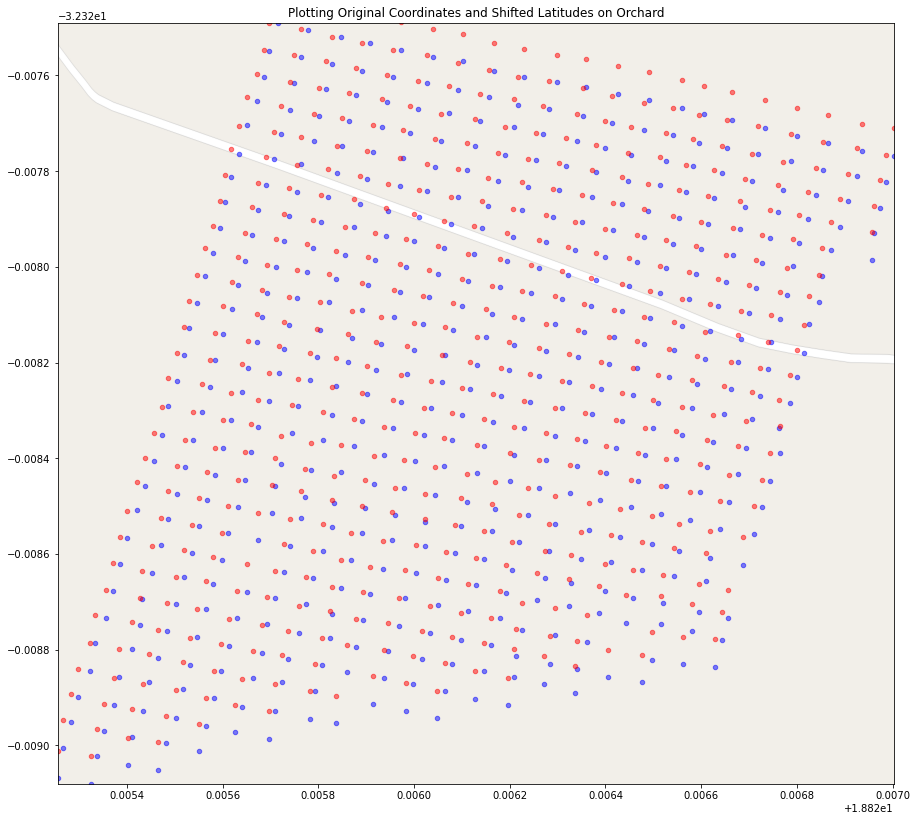

In [50]:
fig, ax = plt.subplots(figsize = (15,14))

ax.scatter(treesurvey_df.longitude, treesurvey_df.latitude, zorder=1, alpha = 0.5, c='b', s=20)
ax.scatter(treesurvey_df.longitude, treesurvey_df.newlat, zorder=1, alpha = 0.5, c='r', s=20)

ax.set_title('Plotting Original Coordinates and Shifted Latitudes on Orchard')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2], bbox[3])

ax.imshow(farm_map, zorder=0, extent = bbox, aspect = 'equal')

#### Double Plotting - Shifted Points
- Results look promising actually, I only used latitude as a test - it could be worthwhile shifting the longitude as well -  but maybe by a quarter of the latitude shift (probably something very smart about earth angles but I have no time!)
- Lets try and see

In [51]:
# Upgrade the Function to Shift the Longitude & Latutude by a specific amount of metres
def newpoints(lat, lon):
    
    r_earth = earth_radius
    
    dy = avg_tree_distance / 1000
    dx = (avg_tree_distance / 1000) / 4
    pi = math.pi
    cos = math.cos
    
    # current tree points
    latitude = lat
    longitude = lon

    new_latitude = latitude + (dy / r_earth) * (180 / pi)
    new_longitude = longitude + (dx / r_earth) * (180 / pi) / cos(latitude * pi/180)
    
    return new_latitude, new_longitude      

In [52]:
treesurvey_df[["newlat", "newlon"]] = treesurvey_df.apply(lambda x: newpoints(x.latitude, x.longitude), axis=1, result_type="expand")
treesurvey_df.head()

,area,height,id,latitude,longitude,ndre,ndvi,radius,survey_id,tree_id,volume,orchard_id,latitude_rad,longitude_rad,newlat,newlon
0,20.703,2.928,54732944,-32.327591,18.826167,0.639,0.893,2.567,25319,38869352,35.639,216269,-0.564223,0.328579,-32.327533,18.826184
1,22.964,2.571,54732945,-32.327561,18.826040,0.608,0.900,2.704,25319,38869351,37.536,216269,-0.564222,0.328576,-32.327503,18.826057
2,23.039,2.916,54732946,-32.327546,18.825974,0.572,0.869,2.708,25319,38869350,44.041,216269,-0.564222,0.328575,-32.327489,18.825991
3,19.014,2.783,54732947,-32.327571,18.826103,0.607,0.913,2.460,25319,38869349,36.735,216269,-0.564223,0.328577,-32.327513,18.826120
4,23.766,3.220,54732948,-32.327561,18.825765,0.614,0.877,2.750,25319,38869348,43.370,216269,-0.564222,0.328572,-32.327503,18.825782


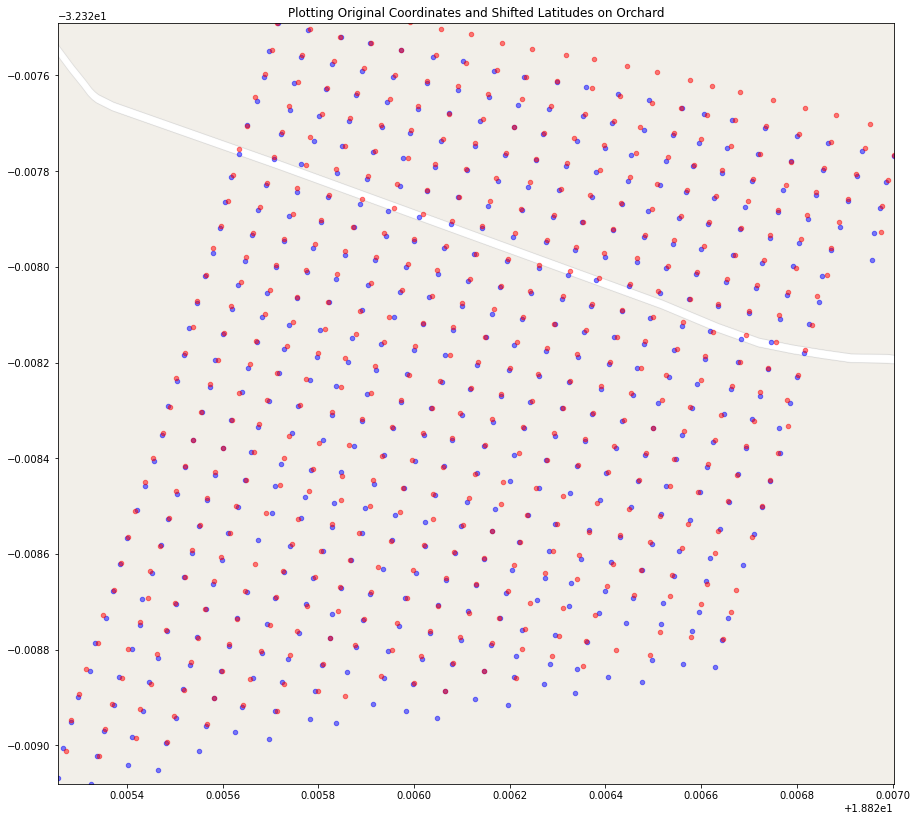

In [53]:
fig, ax = plt.subplots(figsize = (15,14))

ax.scatter(treesurvey_df.longitude, treesurvey_df.latitude, zorder=1, alpha = 0.5, c='b', s=20)
ax.scatter(treesurvey_df.newlon, treesurvey_df.newlat, zorder=1, alpha = 0.5, c='r', s=20)

ax.set_title('Plotting Original Coordinates and Shifted Latitudes on Orchard')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2], bbox[3])

ax.imshow(farm_map, zorder=0, extent = bbox, aspect = 'equal')

#### Double Plotting - Both Shifted Points
- Im getting excited now about my random idea, this image looks really great!
- Im immediately noticing that the points being projected into the missing gaps are pretty lonely (i.e they dont have a blue original near them)
- The top edge ones are similar to the missing ones - I can possibly handle those later with the polygon dataset (edges) or something
#### Next Strategy
- If I can create these new lats and long on the fly, what if I can check them against the rest of the orchard before deciding the should be "allowed"
- So the logic is: create a new point (red) and then check if that new point has a neighbour close to it ( a blue neighbour)
- If the new point does have a blue neighbour close to it, reject the creation
- One question is - how close are these reds and blues from each other?
- Im going to calculate a new ball tree model to see

In [54]:
# Create a BLUE set - the original points
blue_df = treesurvey_df[['tree_id', 'latitude', 'longitude', 'orchard_id']].copy()

In [55]:
blue_df.head()

,tree_id,latitude,longitude,orchard_id
0,38869352,-32.327591,18.826167,216269
1,38869351,-32.327561,18.826040,216269
2,38869350,-32.327546,18.825974,216269
3,38869349,-32.327571,18.826103,216269
4,38869348,-32.327561,18.825765,216269


In [56]:
# Create a RED set - the new points
red_df = treesurvey_df[['tree_id', 'newlat', 'newlon', 'orchard_id']].copy()
red_df.columns = ['treeid', 'latitude', 'longitude', 'orchard_id']

In [57]:
red_df.head()

,treeid,latitude,longitude,orchard_id
0,38869352,-32.327533,18.826184,216269
1,38869351,-32.327503,18.826057,216269
2,38869350,-32.327489,18.825991,216269
3,38869349,-32.327513,18.826120,216269
4,38869348,-32.327503,18.825782,216269


In [58]:
# Creates new columns converting coordinate degrees to radians.
for column in blue_df[["latitude", "longitude"]]:
    rad = np.deg2rad(blue_df[column].values)
    blue_df[f'{column}_rad'] = rad
    
for column in red_df[["latitude", "longitude"]]:
    rad = np.deg2rad(red_df[column].values)
    red_df[f'{column}_rad'] = rad
    
# Takes the first group's latitude and longitude values to construct
# the ball tree.
ball = BallTree(blue_df[["latitude_rad", "longitude_rad"]].values, metric='haversine')
# The amount of neighbors to return. We can now do 1 because it will compare blue vs red (lets see what the closest blue tree is to the reds)
k = 1
# Executes a query with the second group. This will also return two
# arrays. We will use the whole orchard to test
distances, indices = ball.query(red_df[["latitude_rad", "longitude_rad"]].values, k = k)

In [59]:
indices_dataset = pd.DataFrame({'tree_1': indices[:, 0]})
distances_dataset = pd.DataFrame({'distance_1': distances[:, 0]})

indices_dataset = indices_dataset.applymap(get_treeids)
indices_dataset.columns = ['tree_1']

distances_dataset = distances_dataset.applymap(us_to_km)
distances_dataset.columns = ['distance_1']

merger = pd.merge(indices_dataset,distances_dataset, left_index=True,right_index=True)
bluevsred_balltree_df = pd.merge(red_df,merger, left_index=True,right_index=True)
bluevsred_balltree_df.head()

,treeid,latitude,longitude,orchard_id,latitude_rad,longitude_rad,tree_1,distance_1
0,38869352,-32.327533,18.826184,216269,-0.564222,0.328579,38869352,6.598422
1,38869351,-32.327503,18.826057,216269,-0.564221,0.328577,38869352,6.598422
2,38869350,-32.327489,18.825991,216269,-0.564221,0.328576,38869352,6.598422
3,38869349,-32.327513,18.826120,216269,-0.564222,0.328578,38869352,6.598422
4,38869348,-32.327503,18.825782,216269,-0.564221,0.328572,38869352,0.445894


In [60]:
blue_distance_mean = bluevsred_balltree_df["distance_1"].mean()
print(blue_distance_mean)

0.9387820973823765


In [61]:
bluevsred_balltree_df['distance_1'].describe()

count    508.000000
mean       0.938782
std        1.306096
min        0.014850
25%        0.439974
50%        0.645424
75%        0.874048
max        6.598422
Name: distance_1, dtype: float64

#### Blue vs Red Results
- So the average distance came out to a very low 0,94 metres
- when we look at the 75% stat it is at 0,87 metres
- Lets double that to about 2 metres to be sure we catch most points and filter the table down

In [62]:
check = bluevsred_balltree_df[bluevsred_balltree_df['distance_1'] > 2]
check.sort_values(['latitude'], ascending=[False])

,treeid,latitude,longitude,orchard_id,latitude_rad,longitude_rad,tree_1,distance_1
6,38869346,-32.327432,18.825732,216269,-0.564220,0.328571,38869352,6.598422
9,38869343,-32.327448,18.825795,216269,-0.564220,0.328572,38869352,6.598422
8,38869344,-32.327463,18.825865,216269,-0.564221,0.328573,38869352,6.598422
10,38869342,-32.327476,18.825924,216269,-0.564221,0.328574,38869352,6.598422
2,38869350,-32.327489,18.825991,216269,-0.564221,0.328576,38869352,6.598422
1,38869351,-32.327503,18.826057,216269,-0.564221,0.328577,38869352,6.598422
3,38869349,-32.327513,18.826120,216269,-0.564222,0.328578,38869352,6.598422
0,38869352,-32.327533,18.826184,216269,-0.564222,0.328579,38869352,6.598422
430,38869376,-32.327545,18.826247,216269,-0.564222,0.328580,38869352,6.598422
87,38869399,-32.327556,18.826317,216269,-0.564222,0.328581,38869352,6.598422


#### Blue vs Red Results Contd
- Sorting the new filtered table by Latitude, I can see that the straight row of reds on top of the orchard are grouped together
- They also display the same measure for distance_1
- There are 4 points that are different to these
- Lets extract them and plot them

In [63]:
newplot = check.nsmallest(4,'latitude')
newplot

,treeid,latitude,longitude,orchard_id,latitude_rad,longitude_rad,tree_1,distance_1
117,38869753,-32.328896,18.825855,216269,-0.564246,0.328573,38869352,5.399534
59,38868729,-32.328801,18.826421,216269,-0.564244,0.328583,38869352,5.909952
81,38868707,-32.328676,18.826672,216269,-0.564242,0.328587,38869352,6.080864
208,38869622,-32.328622,18.825668,216269,-0.564241,0.328570,38869352,5.679865


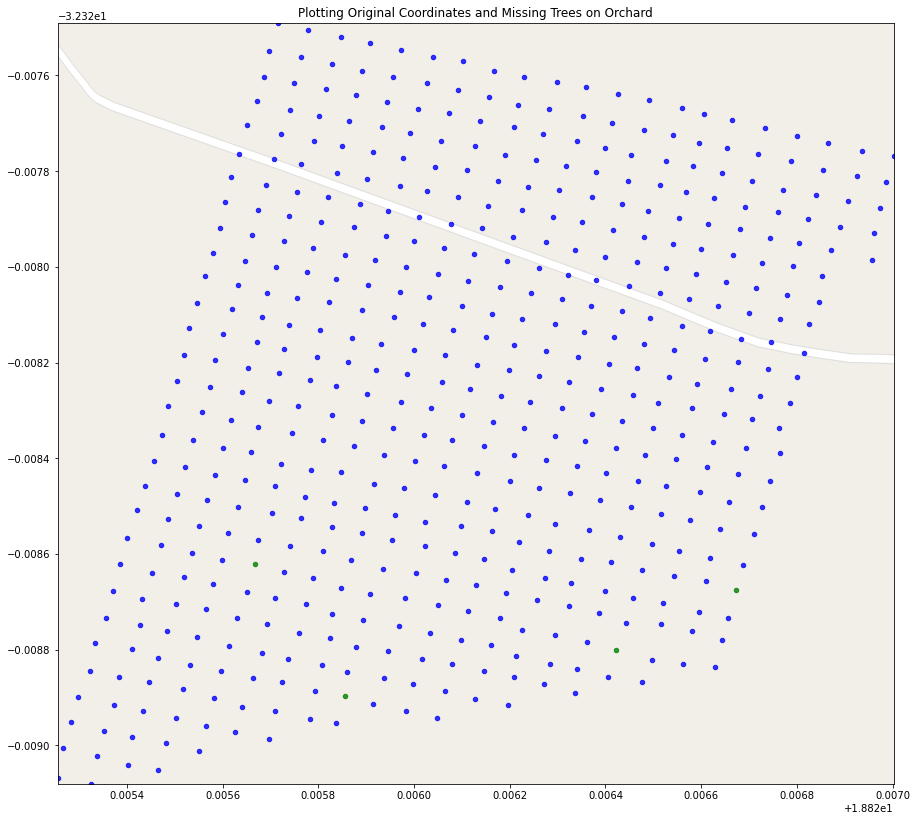

In [64]:
fig, ax = plt.subplots(figsize = (15,14))

ax.scatter(treesurvey_df.longitude, treesurvey_df.latitude, zorder=1, alpha = 0.8, c='b', s=20)
ax.scatter(newplot.longitude, newplot.latitude, zorder=1, alpha = 0.8, c='g', s=20)

ax.set_title('Plotting Original Coordinates and Missing Trees on Orchard')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2], bbox[3])

ax.imshow(farm_map, zorder=0, extent = bbox, aspect = 'equal')

#### Missing Trees
- Looks like we found 4 missing trees!
- Lets upload them to the database so that the results can be utilised in the API

In [65]:
# SETUP THE CONN TO THE DB
param_dic = {
    "host"      : "{{db_url}}",
    "database"  : "{{db_table}}",
    "user"      : "{{db_user}}",
    "password"  : "{{db_password}}"
}

def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

# FUNCTION TO UPLOAD DATA TO POSTGRES DB
def copy_from_stringio(conn, df, table):
    """
    Here we are going save the dataframe in memory 
    and use copy_from() to copy it to the table
    """
    # save dataframe to an in memory buffer
    buffer = StringIO()
    df.to_csv(buffer, index_label='id', header=False)
    buffer.seek(0)
    
    cursor = conn.cursor()
    try:
        cursor.copy_from(buffer, table, sep=",")
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
#         os.remove(tmp_df)
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("{} upload done".format(table))
    cursor.close()

In [66]:
# Create the upload set fro DB
missing_trees_df = newplot[['orchard_id', 'latitude', 'longitude']].copy()
missing_trees_df.columns = ['orchard_id', 'lat', 'lng']
missing_trees_df

,orchard_id,lat,lng
117,216269,-32.328896,18.825855
59,216269,-32.328801,18.826421
81,216269,-32.328676,18.826672
208,216269,-32.328622,18.825668


In [69]:
# TRUNCTATE THE TABLE IN THE DB NOW - OPEN THE CONNECTION FOR THE FIRST TIME
conn = connect(param_dic)
cursor = conn.cursor()
cursor.execute('TRUNCATE TABLE {{db_table}}')
conn.commit()
cursor.close()

# orchard_id, lat , lng
# Upload missing tree data to database
copy_from_stringio(conn,missing_trees_df,'{{db_table}}')

Connecting to the PostgreSQL database...
Connection successful
missingtrees upload done
